In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
import molvs
from multiprocessing import Pool, cpu_count
from tqdm.auto import tqdm

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/5l7i/molsnapper/use_pharma_true
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/5l7i/molsnapper


Reading data from crossdock dataset, add a standardization for small molecule data:

In [3]:
standardizer = molvs.standardize.Standardizer()

def standardize_mol(mol):
    try:
        mol = standardizer.standardize(mol)
        mol = standardizer.fragment_parent(mol, skip_standardize=True)
        mol = standardizer.tautomer_parent(mol, skip_standardize=True)
        mol = standardizer.isotope_parent(mol, skip_standardize=True)
        mol = standardizer.charge_parent(mol, skip_standardize=True)
        return mol
    except:
        return None

In [4]:
smi_list = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/5l7i/molsnapper/use_pharma_true/500_generated.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in tqdm(smi_list, desc="Standardizing molecules", unit="mol"):
    mol = Chem.MolFromSmiles(smi)
    mol = standardize_mol(mol)
    
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))
    else:
        print(f"Skipping molecule {smi}")
        pass

print(len(smi_list))
len(standardized_smiles_list)

Standardizing molecules:   0%|          | 0/503 [00:00<?, ?mol/s]

503


503

Set the default image size

In [5]:
with open('500_generated_standardized.smi', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

In [6]:
uru.rd_set_image_size(300,300)

Convert SMILES and name of them to a dataframe

In [7]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...
1,CSc1cccc(NS(=O)(=O)c2cccc(NC(=O)CN3C(=O)N=C4C=...
2,CCN1CC(Oc2ccc(O)c(NC(=O)c3cccnc3)c2)NC2NCCCC21
3,N#CC1C2CCC(=O)C(OCC(=O)Nc3cccc(Cl)c3)C2CNC1N1C...
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1
...,...
498,O=C1CCN(C2CC3N4CCCCC4N3C(=O)N2)C(=O)C1NCCCc1cc...
499,Nc1cccc(NC(=O)C23CC24C2CC5C3C5C24C2CC3C4N3C4([...
500,COc1cc(C=CC2CNC3CCCCC3N2C=O)cc(O)c1NCc1cccnc1
501,Cc1ccc(NC(=O)C2CCC3NC4(CN4)C(Nc4ccccc4)NC3C2)c...


Remove repeated molecules

In [8]:
df = df.drop_duplicates(['SMILES'])
df.reset_index(inplace=True, drop=True)
df

,SMILES
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...
1,CSc1cccc(NS(=O)(=O)c2cccc(NC(=O)CN3C(=O)N=C4C=...
2,CCN1CC(Oc2ccc(O)c(NC(=O)c3cccnc3)c2)NC2NCCCC21
3,N#CC1C2CCC(=O)C(OCC(=O)Nc3cccc(Cl)c3)C2CNC1N1C...
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1
...,...
494,O=C1CCN(C2CC3N4CCCCC4N3C(=O)N2)C(=O)C1NCCCc1cc...
495,Nc1cccc(NC(=O)C23CC24C2CC5C3C5C24C2CC3C4N3C4([...
496,COc1cc(C=CC2CNC3CCCCC3N2C=O)cc(O)c1NCc1cccnc1
497,Cc1ccc(NC(=O)C2CCC3NC4(CN4)C(Nc4ccccc4)NC3C2)c...


Save the smi file for further use

Add an RDKit molecule to the dataframe

In [9]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

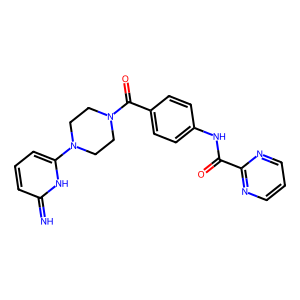

In [10]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [11]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0         [N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]
1               [c1ccccc1, c1ccccc1, O=C1N=C2C=CC=C2N1]
2                  [C1CNC2NCCNC2C1, c1ccccc1, c1ccncc1]
3                [O=C1CCC2CCNCC2C1, c1ccccc1, C1COCCN1]
4             [c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]
                             ...                       
494    [O=C1CCNC(=O)C1, O=C1NCCC2N3CCCCC3N12, c1ccccc1]
495    [c1ccccc1, C1C2C3C2C2C1C21CC31, C1CC2C3C(C1)N23]
496                [c1ccccc1, C1CCC2NCCNC2C1, c1ccncc1]
497          [c1ccccc1, C1CCC2NC3(CNC2C1)CN3, c1ccccc1]
498             [c1ccccc1, O=C1CCCC2C1CCC1C2NC2CCCCN21]
Name: ring_sytems, Length: 499, dtype: object

In [12]:
df.ring_sytems.values

array([list(['N=c1cccc[nH]1', 'C1CNCCN1', 'c1ccccc1', 'c1cncnc1']),
       list(['c1ccccc1', 'c1ccccc1', 'O=C1N=C2C=CC=C2N1']),
       list(['C1CNC2NCCNC2C1', 'c1ccccc1', 'c1ccncc1']),
       list(['O=C1CCC2CCNCC2C1', 'c1ccccc1', 'C1COCCN1']),
       list(['c1ccccc1', 'c1ccccc1', 'O=c1[nH]cnc2ccccc12']),
       list(['c1ccccc1', 'c1ccccc1', 'O=C1NCCC2NC3CCCCC3N12']),
       list(['c1ccncc1', 'c1ccccc1', 'C1CCN2C(C1)NC1C3NCC2C31']),
       list(['c1ccncc1', 'C1=CC2=NC=C3C=c4ccccc4=CC=C3N2C=C1']),
       list(['O=c1cnc2c3c(ccc2[nH]1)-c1[nH]c(=O)[nH]c(=O)c1CC3', 'c1ccccc1']),
       list(['C1CCNCC1', 'O=C1C2CC3CCCCCC3CC2C2CCCCN12']),
       list(['c1ccccc1', 'c1ccccc1', 'c1ccn2cnnc2c1']),
       list(['c1ccccc1', 'c1ccccc1', 'O=C1NC2CCCC3CCCCC1N32']),
       list(['c1ccccc1', 'c1ccccc1', 'O=C1CNC2CCCCC2N1']),
       list(['c1ccc2c(c1)CNCO2', 'c1ccncc1', 'C1CNC2CCNCCN2C1']),
       list(['O=C1NC2C3C45Cn6c(cc7ncccc76)NC34CC23OC13C5']),
       list(['c1ccccc1', 'c1ccccc1', 'O=C1NCNC2NCCCCN12

See how many times each ring system occurs

In [13]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
2,c1ccccc1,589
6,c1ccncc1,66
51,C1CCN2CCCNC2C1,25
14,C1CCNCC1,25
54,C1CCC2NCNC2C1,16
...,...,...
161,O=C1NNC2CCCCN12,1
159,O=C1N[N+]12CCC1(CC2)C(=O)[N+]12CCN1CCCC3=NC31CC2,1
158,C1CNC2CON=C2C1,1
156,O=C1NCNC2NCCCC12,1


View the ring system frequencies

In [14]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [15]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

In [16]:
res

0      [(N=c1cccc[nH]1, 151), (C1CNCCN1, 161505), (c1...
1      [(c1ccccc1, 2568039), (c1ccccc1, 2568039), (O=...
2      [(C1CNC2NCCNC2C1, 0), (c1ccccc1, 2568039), (c1...
3      [(O=C1CCC2CCNCC2C1, 0), (c1ccccc1, 2568039), (...
4      [(c1ccccc1, 2568039), (c1ccccc1, 2568039), (O=...
                             ...                        
494    [(O=C1CCNC(=O)C1, 9), (O=C1NCCC2N3CCCCC3N12, 0...
495    [(c1ccccc1, 2568039), (C1C2C3C2C2C1C21CC31, 0)...
496    [(c1ccccc1, 2568039), (C1CCC2NCCNC2C1, 26), (c...
497    [(c1ccccc1, 2568039), (C1CCC2NC3(CNC2C1)CN3, 0...
498    [(c1ccccc1, 2568039), (O=C1CCCC2C1CCC1C2NC2CCC...
Name: mol, Length: 499, dtype: object

In [17]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5b60>,"[N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]",N=c1cccc[nH]1,151
1,CSc1cccc(NS(=O)(=O)c2cccc(NC(=O)CN3C(=O)N=C4C=...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5bd0>,"[c1ccccc1, c1ccccc1, O=C1N=C2C=CC=C2N1]",O=C1N=C2C=CC=C2N1,0
2,CCN1CC(Oc2ccc(O)c(NC(=O)c3cccnc3)c2)NC2NCCCC21,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5c40>,"[C1CNC2NCCNC2C1, c1ccccc1, c1ccncc1]",C1CNC2NCCNC2C1,0
3,N#CC1C2CCC(=O)C(OCC(=O)Nc3cccc(Cl)c3)C2CNC1N1C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5cb0>,"[O=C1CCC2CCNCC2C1, c1ccccc1, C1COCCN1]",O=C1CCC2CCNCC2C1,0
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5d20>,"[c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]",O=c1[nH]cnc2ccccc12,13851
...,...,...,...,...,...
494,O=C1CCN(C2CC3N4CCCCC4N3C(=O)N2)C(=O)C1NCCCc1cc...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9d90>,"[O=C1CCNC(=O)C1, O=C1NCCC2N3CCCCC3N12, c1ccccc1]",O=C1NCCC2N3CCCCC3N12,0
495,Nc1cccc(NC(=O)C23CC24C2CC5C3C5C24C2CC3C4N3C4([...,<rdkit.Chem.rdchem.Mol object at 0x70f6410da110>,"[c1ccccc1, C1C2C3C2C2C1C21CC31, C1CC2C3C(C1)N23]",C1C2C3C2C2C1C21CC31,0
496,COc1cc(C=CC2CNC3CCCCC3N2C=O)cc(O)c1NCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9fc0>,"[c1ccccc1, C1CCC2NCCNC2C1, c1ccncc1]",C1CCC2NCCNC2C1,26
497,Cc1ccc(NC(=O)C2CCC3NC4(CN4)C(Nc4ccccc4)NC3C2)c...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9f50>,"[c1ccccc1, C1CCC2NC3(CNC2C1)CN3, c1ccccc1]",C1CCC2NC3(CNC2C1)CN3,0


In [18]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [19]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49] WARNING: Proton(s) added/removed; Omitted undefined stereo

[16:16:49] WARNING: Omitted undefined stereo

[16:16:49

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5b60>,"[N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]",N=c1cccc[nH]1,151,InChI=1S/C21H21N7O2/c22-17-3-1-4-18(26-17)27-1...
1,CSc1cccc(NS(=O)(=O)c2cccc(NC(=O)CN3C(=O)N=C4C=...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5bd0>,"[c1ccccc1, c1ccccc1, O=C1N=C2C=CC=C2N1]",O=C1N=C2C=CC=C2N1,0,InChI=1S/C21H18N4O4S2/c1-30-16-7-2-6-15(11-16)...
2,CCN1CC(Oc2ccc(O)c(NC(=O)c3cccnc3)c2)NC2NCCCC21,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5c40>,"[C1CNC2NCCNC2C1, c1ccccc1, c1ccncc1]",C1CNC2NCCNC2C1,0,InChI=1S/C21H27N5O3/c1-2-26-13-19(25-20-17(26)...
3,N#CC1C2CCC(=O)C(OCC(=O)Nc3cccc(Cl)c3)C2CNC1N1C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5cb0>,"[O=C1CCC2CCNCC2C1, c1ccccc1, C1COCCN1]",O=C1CCC2CCNCC2C1,0,InChI=1S/C22H27ClN4O4/c23-14-2-1-3-15(10-14)26...
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5d20>,"[c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]",O=c1[nH]cnc2ccccc12,13851,InChI=1S/C22H17N5O3/c23-20(28)15-4-3-5-17(12-1...
...,...,...,...,...,...,...
494,O=C1CCN(C2CC3N4CCCCC4N3C(=O)N2)C(=O)C1NCCCc1cc...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9d90>,"[O=C1CCNC(=O)C1, O=C1NCCC2N3CCCCC3N12, c1ccccc1]",O=C1NCCC2N3CCCCC3N12,0,InChI=1S/C23H31N5O3/c29-17-11-14-26(22(30)21(1...
495,Nc1cccc(NC(=O)C23CC24C2CC5C3C5C24C2CC3C4N3C4([...,<rdkit.Chem.rdchem.Mol object at 0x70f6410da110>,"[c1ccccc1, C1C2C3C2C2C1C21CC31, C1CC2C3C(C1)N23]",C1C2C3C2C2C1C21CC31,0,InChI=1S/C22H22N4O3/c23-10-2-1-3-11(5-10)24-18...
496,COc1cc(C=CC2CNC3CCCCC3N2C=O)cc(O)c1NCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9fc0>,"[c1ccccc1, C1CCC2NCCNC2C1, c1ccncc1]",C1CCC2NCCNC2C1,26,InChI=1S/C24H30N4O3/c1-31-23-12-17(11-22(30)24...
497,Cc1ccc(NC(=O)C2CCC3NC4(CN4)C(Nc4ccccc4)NC3C2)c...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9f50>,"[c1ccccc1, C1CCC2NC3(CNC2C1)CN3, c1ccccc1]",C1CCC2NC3(CNC2C1)CN3,0,InChI=1S/C24H28N6O/c1-15-7-9-19(11-17(15)13-25...


How many of them have ring system?

In [20]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5b60>,"[N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]",N=c1cccc[nH]1,151,InChI=1S/C21H21N7O2/c22-17-3-1-4-18(26-17)27-1...
1,CSc1cccc(NS(=O)(=O)c2cccc(NC(=O)CN3C(=O)N=C4C=...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5bd0>,"[c1ccccc1, c1ccccc1, O=C1N=C2C=CC=C2N1]",O=C1N=C2C=CC=C2N1,0,InChI=1S/C21H18N4O4S2/c1-30-16-7-2-6-15(11-16)...
2,CCN1CC(Oc2ccc(O)c(NC(=O)c3cccnc3)c2)NC2NCCCC21,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5c40>,"[C1CNC2NCCNC2C1, c1ccccc1, c1ccncc1]",C1CNC2NCCNC2C1,0,InChI=1S/C21H27N5O3/c1-2-26-13-19(25-20-17(26)...
3,N#CC1C2CCC(=O)C(OCC(=O)Nc3cccc(Cl)c3)C2CNC1N1C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5cb0>,"[O=C1CCC2CCNCC2C1, c1ccccc1, C1COCCN1]",O=C1CCC2CCNCC2C1,0,InChI=1S/C22H27ClN4O4/c23-14-2-1-3-15(10-14)26...
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5d20>,"[c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]",O=c1[nH]cnc2ccccc12,13851,InChI=1S/C22H17N5O3/c23-20(28)15-4-3-5-17(12-1...
...,...,...,...,...,...,...
494,O=C1CCN(C2CC3N4CCCCC4N3C(=O)N2)C(=O)C1NCCCc1cc...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9d90>,"[O=C1CCNC(=O)C1, O=C1NCCC2N3CCCCC3N12, c1ccccc1]",O=C1NCCC2N3CCCCC3N12,0,InChI=1S/C23H31N5O3/c29-17-11-14-26(22(30)21(1...
495,Nc1cccc(NC(=O)C23CC24C2CC5C3C5C24C2CC3C4N3C4([...,<rdkit.Chem.rdchem.Mol object at 0x70f6410da110>,"[c1ccccc1, C1C2C3C2C2C1C21CC31, C1CC2C3C(C1)N23]",C1C2C3C2C2C1C21CC31,0,InChI=1S/C22H22N4O3/c23-10-2-1-3-11(5-10)24-18...
496,COc1cc(C=CC2CNC3CCCCC3N2C=O)cc(O)c1NCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9fc0>,"[c1ccccc1, C1CCC2NCCNC2C1, c1ccncc1]",C1CCC2NCCNC2C1,26,InChI=1S/C24H30N4O3/c1-31-23-12-17(11-22(30)24...
497,Cc1ccc(NC(=O)C2CCC3NC4(CN4)C(Nc4ccccc4)NC3C2)c...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9f50>,"[c1ccccc1, C1CCC2NC3(CNC2C1)CN3, c1ccccc1]",C1CCC2NC3(CNC2C1)CN3,0,InChI=1S/C24H28N6O/c1-15-7-9-19(11-17(15)13-25...


In [21]:
filtered_df_ring_freq = df[df.min_freq > 100]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5b60>,"[N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]",N=c1cccc[nH]1,151,InChI=1S/C21H21N7O2/c22-17-3-1-4-18(26-17)27-1...
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5d20>,"[c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]",O=c1[nH]cnc2ccccc12,13851,InChI=1S/C22H17N5O3/c23-20(28)15-4-3-5-17(12-1...
10,NC(=O)c1cccc(NC(=O)c2ccc(NC(=O)Cc3nnc4ccccn34)...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5fc0>,"[c1ccccc1, c1ccccc1, c1ccn2cnnc2c1]",c1ccn2cnnc2c1,2753,InChI=1S/C22H18N6O3/c23-21(30)15-4-3-5-17(12-1...
17,NC(=O)c1cccc(Nc2cc(C=CC(=O)n3cnc4ccccc43)ccc2O)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d62d0>,"[c1ccccc1, c1ccccc1, c1ccc2[nH]cnc2c1]",c1ccc2[nH]cnc2c1,49899,InChI=1S/C23H18N4O3/c24-23(30)16-4-3-5-17(13-1...
18,CNCCCCNC(=O)c1ccc(N2CCn3c(nc4ccccc43)C2)cc1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d6340>,"[c1ccccc1, c1ccc2c(c1)nc1n2CCNC1]",c1ccc2c(c1)nc1n2CCNC1,245,InChI=1S/C22H27N5O/c1-23-12-4-5-13-24-22(28)17...
...,...,...,...,...,...,...
475,CCN1CCCN=C1NC(=O)c1cccc(C(=O)Nc2cccc(C#N)c2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410db8b0>,"[C1=NCCCN1, c1ccccc1, c1ccccc1]",C1=NCCCN1,1240,InChI=1S/C21H21N5O2/c1-2-26-11-5-10-23-21(26)2...
482,CC1CCNCN1CC(=O)Nc1cccc(S(=O)(=O)Nc2cccc([N+](=...,<rdkit.Chem.rdchem.Mol object at 0x70f6410db1b0>,"[C1CNCNC1, c1ccccc1, c1ccccc1]",C1CNCNC1,137,InChI=1S/C19H23N5O5S/c1-14-8-9-20-13-23(14)12-...
485,Cn1c(=O)[nH]c(O)c(C(=O)c2cccc(C(=O)NCc3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x70f6410daf10>,"[O=c1cc[nH]c(=O)[nH]1, c1ccccc1, c1ccccc1]",O=c1cc[nH]c(=O)[nH]1,22444,InChI=1S/C20H17N3O5/c1-23-19(27)15(18(26)22-20...
486,O=C(c1ccc(S(=O)(=O)Nc2ccccc2)cc1)N1CCN(C2NCCN2...,<rdkit.Chem.rdchem.Mol object at 0x70f6410daa40>,"[c1ccccc1, c1ccccc1, C1CNCCN1, C1CNCN1]",C1CNCN1,417,InChI=1S/C20H25N5O3S/c26-19(24-12-14-25(15-13-...


### How many of them could pass PAINS filter?

Get a list of rules

In [22]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [23]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [24]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [25]:
reos.pandas_mols(df.mol)

  0%|          | 0/499 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,ok,ok
4,ok,ok
...,...,...
494,ok,ok
495,ok,ok
496,ok,ok
497,ok,ok


In [26]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/499 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5b60>,"[N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]",N=c1cccc[nH]1,151,InChI=1S/C21H21N7O2/c22-17-3-1-4-18(26-17)27-1...,ok,ok
1,CSc1cccc(NS(=O)(=O)c2cccc(NC(=O)CN3C(=O)N=C4C=...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5bd0>,"[c1ccccc1, c1ccccc1, O=C1N=C2C=CC=C2N1]",O=C1N=C2C=CC=C2N1,0,InChI=1S/C21H18N4O4S2/c1-30-16-7-2-6-15(11-16)...,ok,ok
2,CCN1CC(Oc2ccc(O)c(NC(=O)c3cccnc3)c2)NC2NCCCC21,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5c40>,"[C1CNC2NCCNC2C1, c1ccccc1, c1ccncc1]",C1CNC2NCCNC2C1,0,InChI=1S/C21H27N5O3/c1-2-26-13-19(25-20-17(26)...,ok,ok
3,N#CC1C2CCC(=O)C(OCC(=O)Nc3cccc(Cl)c3)C2CNC1N1C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5cb0>,"[O=C1CCC2CCNCC2C1, c1ccccc1, C1COCCN1]",O=C1CCC2CCNCC2C1,0,InChI=1S/C22H27ClN4O4/c23-14-2-1-3-15(10-14)26...,ok,ok
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5d20>,"[c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]",O=c1[nH]cnc2ccccc12,13851,InChI=1S/C22H17N5O3/c23-20(28)15-4-3-5-17(12-1...,ok,ok
...,...,...,...,...,...,...,...,...
494,O=C1CCN(C2CC3N4CCCCC4N3C(=O)N2)C(=O)C1NCCCc1cc...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9d90>,"[O=C1CCNC(=O)C1, O=C1NCCC2N3CCCCC3N12, c1ccccc1]",O=C1NCCC2N3CCCCC3N12,0,InChI=1S/C23H31N5O3/c29-17-11-14-26(22(30)21(1...,ok,ok
495,Nc1cccc(NC(=O)C23CC24C2CC5C3C5C24C2CC3C4N3C4([...,<rdkit.Chem.rdchem.Mol object at 0x70f6410da110>,"[c1ccccc1, C1C2C3C2C2C1C21CC31, C1CC2C3C(C1)N23]",C1C2C3C2C2C1C21CC31,0,InChI=1S/C22H22N4O3/c23-10-2-1-3-11(5-10)24-18...,ok,ok
496,COc1cc(C=CC2CNC3CCCCC3N2C=O)cc(O)c1NCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9fc0>,"[c1ccccc1, C1CCC2NCCNC2C1, c1ccncc1]",C1CCC2NCCNC2C1,26,InChI=1S/C24H30N4O3/c1-31-23-12-17(11-22(30)24...,ok,ok
497,Cc1ccc(NC(=O)C2CCC3NC4(CN4)C(Nc4ccccc4)NC3C2)c...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9f50>,"[c1ccccc1, C1CCC2NC3(CNC2C1)CN3, c1ccccc1]",C1CCC2NC3(CNC2C1)CN3,0,InChI=1S/C24H28N6O/c1-15-7-9-19(11-17(15)13-25...,ok,ok


Test all filters from rd filters

In [27]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/499 [00:00<?, ?it/s]

Glaxo 0.7995991983967936 ['Glaxo'] 399


  0%|          | 0/499 [00:00<?, ?it/s]

Dundee 0.47695390781563124 ['Dundee'] 238


  0%|          | 0/499 [00:00<?, ?it/s]

BMS 0.7474949899799599 ['BMS'] 373


  0%|          | 0/499 [00:00<?, ?it/s]

SureChEMBL 0.7034068136272545 ['SureChEMBL'] 351


  0%|          | 0/499 [00:00<?, ?it/s]

MLSMR 0.45490981963927857 ['MLSMR'] 227


  0%|          | 0/499 [00:00<?, ?it/s]

Inpharmatica 0.6472945891783567 ['Inpharmatica'] 323


  0%|          | 0/499 [00:00<?, ?it/s]

LINT 0.6452905811623246 ['LINT'] 322


### How many of them could pass filters suggested by Dr.Reymond?

In [28]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5b60>,"[N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]",N=c1cccc[nH]1,151,InChI=1S/C21H21N7O2/c22-17-3-1-4-18(26-17)27-1...,True
1,CSc1cccc(NS(=O)(=O)c2cccc(NC(=O)CN3C(=O)N=C4C=...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5bd0>,"[c1ccccc1, c1ccccc1, O=C1N=C2C=CC=C2N1]",O=C1N=C2C=CC=C2N1,0,InChI=1S/C21H18N4O4S2/c1-30-16-7-2-6-15(11-16)...,True
2,CCN1CC(Oc2ccc(O)c(NC(=O)c3cccnc3)c2)NC2NCCCC21,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5c40>,"[C1CNC2NCCNC2C1, c1ccccc1, c1ccncc1]",C1CNC2NCCNC2C1,0,InChI=1S/C21H27N5O3/c1-2-26-13-19(25-20-17(26)...,True
3,N#CC1C2CCC(=O)C(OCC(=O)Nc3cccc(Cl)c3)C2CNC1N1C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5cb0>,"[O=C1CCC2CCNCC2C1, c1ccccc1, C1COCCN1]",O=C1CCC2CCNCC2C1,0,InChI=1S/C22H27ClN4O4/c23-14-2-1-3-15(10-14)26...,True
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5d20>,"[c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]",O=c1[nH]cnc2ccccc12,13851,InChI=1S/C22H17N5O3/c23-20(28)15-4-3-5-17(12-1...,True
...,...,...,...,...,...,...,...
494,O=C1CCN(C2CC3N4CCCCC4N3C(=O)N2)C(=O)C1NCCCc1cc...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9d90>,"[O=C1CCNC(=O)C1, O=C1NCCC2N3CCCCC3N12, c1ccccc1]",O=C1NCCC2N3CCCCC3N12,0,InChI=1S/C23H31N5O3/c29-17-11-14-26(22(30)21(1...,True
495,Nc1cccc(NC(=O)C23CC24C2CC5C3C5C24C2CC3C4N3C4([...,<rdkit.Chem.rdchem.Mol object at 0x70f6410da110>,"[c1ccccc1, C1C2C3C2C2C1C21CC31, C1CC2C3C(C1)N23]",C1C2C3C2C2C1C21CC31,0,InChI=1S/C22H22N4O3/c23-10-2-1-3-11(5-10)24-18...,False
496,COc1cc(C=CC2CNC3CCCCC3N2C=O)cc(O)c1NCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9fc0>,"[c1ccccc1, C1CCC2NCCNC2C1, c1ccncc1]",C1CCC2NCCNC2C1,26,InChI=1S/C24H30N4O3/c1-31-23-12-17(11-22(30)24...,True
497,Cc1ccc(NC(=O)C2CCC3NC4(CN4)C(Nc4ccccc4)NC3C2)c...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9f50>,"[c1ccccc1, C1CCC2NC3(CNC2C1)CN3, c1ccccc1]",C1CCC2NC3(CNC2C1)CN3,0,InChI=1S/C24H28N6O/c1-15-7-9-19(11-17(15)13-25...,True


In [29]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5b60>,"[N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]",N=c1cccc[nH]1,151,InChI=1S/C21H21N7O2/c22-17-3-1-4-18(26-17)27-1...,True
1,CSc1cccc(NS(=O)(=O)c2cccc(NC(=O)CN3C(=O)N=C4C=...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5bd0>,"[c1ccccc1, c1ccccc1, O=C1N=C2C=CC=C2N1]",O=C1N=C2C=CC=C2N1,0,InChI=1S/C21H18N4O4S2/c1-30-16-7-2-6-15(11-16)...,True
2,CCN1CC(Oc2ccc(O)c(NC(=O)c3cccnc3)c2)NC2NCCCC21,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5c40>,"[C1CNC2NCCNC2C1, c1ccccc1, c1ccncc1]",C1CNC2NCCNC2C1,0,InChI=1S/C21H27N5O3/c1-2-26-13-19(25-20-17(26)...,True
3,N#CC1C2CCC(=O)C(OCC(=O)Nc3cccc(Cl)c3)C2CNC1N1C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5cb0>,"[O=C1CCC2CCNCC2C1, c1ccccc1, C1COCCN1]",O=C1CCC2CCNCC2C1,0,InChI=1S/C22H27ClN4O4/c23-14-2-1-3-15(10-14)26...,True
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5d20>,"[c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]",O=c1[nH]cnc2ccccc12,13851,InChI=1S/C22H17N5O3/c23-20(28)15-4-3-5-17(12-1...,True
...,...,...,...,...,...,...,...
493,N#Cc1ccc(C2CCCC3(N2)Oc2ccc(NC(=O)CN4CCCCC4=O)c...,<rdkit.Chem.rdchem.Mol object at 0x70f6410da420>,"[c1ccoc1, c1ccc2c(c1)OC21CCCCN1, O=C1CCCCN1]",c1ccc2c(c1)OC21CCCCN1,0,InChI=1S/C23H24N4O4/c24-13-16-7-9-20(30-16)18-...,True
494,O=C1CCN(C2CC3N4CCCCC4N3C(=O)N2)C(=O)C1NCCCc1cc...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9d90>,"[O=C1CCNC(=O)C1, O=C1NCCC2N3CCCCC3N12, c1ccccc1]",O=C1NCCC2N3CCCCC3N12,0,InChI=1S/C23H31N5O3/c29-17-11-14-26(22(30)21(1...,True
496,COc1cc(C=CC2CNC3CCCCC3N2C=O)cc(O)c1NCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9fc0>,"[c1ccccc1, C1CCC2NCCNC2C1, c1ccncc1]",C1CCC2NCCNC2C1,26,InChI=1S/C24H30N4O3/c1-31-23-12-17(11-22(30)24...,True
497,Cc1ccc(NC(=O)C2CCC3NC4(CN4)C(Nc4ccccc4)NC3C2)c...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9f50>,"[c1ccccc1, C1CCC2NC3(CNC2C1)CN3, c1ccccc1]",C1CCC2NC3(CNC2C1)CN3,0,InChI=1S/C24H28N6O/c1-15-7-9-19(11-17(15)13-25...,True


### How many of them could pass RO5?

In [30]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5b60>,"[N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]",N=c1cccc[nH]1,151,InChI=1S/C21H21N7O2/c22-17-3-1-4-18(26-17)27-1...,True,True
1,CSc1cccc(NS(=O)(=O)c2cccc(NC(=O)CN3C(=O)N=C4C=...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5bd0>,"[c1ccccc1, c1ccccc1, O=C1N=C2C=CC=C2N1]",O=C1N=C2C=CC=C2N1,0,InChI=1S/C21H18N4O4S2/c1-30-16-7-2-6-15(11-16)...,True,True
2,CCN1CC(Oc2ccc(O)c(NC(=O)c3cccnc3)c2)NC2NCCCC21,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5c40>,"[C1CNC2NCCNC2C1, c1ccccc1, c1ccncc1]",C1CNC2NCCNC2C1,0,InChI=1S/C21H27N5O3/c1-2-26-13-19(25-20-17(26)...,True,True
3,N#CC1C2CCC(=O)C(OCC(=O)Nc3cccc(Cl)c3)C2CNC1N1C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5cb0>,"[O=C1CCC2CCNCC2C1, c1ccccc1, C1COCCN1]",O=C1CCC2CCNCC2C1,0,InChI=1S/C22H27ClN4O4/c23-14-2-1-3-15(10-14)26...,True,True
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5d20>,"[c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]",O=c1[nH]cnc2ccccc12,13851,InChI=1S/C22H17N5O3/c23-20(28)15-4-3-5-17(12-1...,True,True
...,...,...,...,...,...,...,...,...
494,O=C1CCN(C2CC3N4CCCCC4N3C(=O)N2)C(=O)C1NCCCc1cc...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9d90>,"[O=C1CCNC(=O)C1, O=C1NCCC2N3CCCCC3N12, c1ccccc1]",O=C1NCCC2N3CCCCC3N12,0,InChI=1S/C23H31N5O3/c29-17-11-14-26(22(30)21(1...,True,True
495,Nc1cccc(NC(=O)C23CC24C2CC5C3C5C24C2CC3C4N3C4([...,<rdkit.Chem.rdchem.Mol object at 0x70f6410da110>,"[c1ccccc1, C1C2C3C2C2C1C21CC31, C1CC2C3C(C1)N23]",C1C2C3C2C2C1C21CC31,0,InChI=1S/C22H22N4O3/c23-10-2-1-3-11(5-10)24-18...,False,True
496,COc1cc(C=CC2CNC3CCCCC3N2C=O)cc(O)c1NCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9fc0>,"[c1ccccc1, C1CCC2NCCNC2C1, c1ccncc1]",C1CCC2NCCNC2C1,26,InChI=1S/C24H30N4O3/c1-31-23-12-17(11-22(30)24...,True,True
497,Cc1ccc(NC(=O)C2CCC3NC4(CN4)C(Nc4ccccc4)NC3C2)c...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9f50>,"[c1ccccc1, C1CCC2NC3(CNC2C1)CN3, c1ccccc1]",C1CCC2NC3(CNC2C1)CN3,0,InChI=1S/C24H28N6O/c1-15-7-9-19(11-17(15)13-25...,True,True


In [31]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5b60>,"[N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]",N=c1cccc[nH]1,151,InChI=1S/C21H21N7O2/c22-17-3-1-4-18(26-17)27-1...,True,True
1,CSc1cccc(NS(=O)(=O)c2cccc(NC(=O)CN3C(=O)N=C4C=...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5bd0>,"[c1ccccc1, c1ccccc1, O=C1N=C2C=CC=C2N1]",O=C1N=C2C=CC=C2N1,0,InChI=1S/C21H18N4O4S2/c1-30-16-7-2-6-15(11-16)...,True,True
2,CCN1CC(Oc2ccc(O)c(NC(=O)c3cccnc3)c2)NC2NCCCC21,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5c40>,"[C1CNC2NCCNC2C1, c1ccccc1, c1ccncc1]",C1CNC2NCCNC2C1,0,InChI=1S/C21H27N5O3/c1-2-26-13-19(25-20-17(26)...,True,True
3,N#CC1C2CCC(=O)C(OCC(=O)Nc3cccc(Cl)c3)C2CNC1N1C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5cb0>,"[O=C1CCC2CCNCC2C1, c1ccccc1, C1COCCN1]",O=C1CCC2CCNCC2C1,0,InChI=1S/C22H27ClN4O4/c23-14-2-1-3-15(10-14)26...,True,True
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5d20>,"[c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]",O=c1[nH]cnc2ccccc12,13851,InChI=1S/C22H17N5O3/c23-20(28)15-4-3-5-17(12-1...,True,True
...,...,...,...,...,...,...,...,...
494,O=C1CCN(C2CC3N4CCCCC4N3C(=O)N2)C(=O)C1NCCCc1cc...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9d90>,"[O=C1CCNC(=O)C1, O=C1NCCC2N3CCCCC3N12, c1ccccc1]",O=C1NCCC2N3CCCCC3N12,0,InChI=1S/C23H31N5O3/c29-17-11-14-26(22(30)21(1...,True,True
495,Nc1cccc(NC(=O)C23CC24C2CC5C3C5C24C2CC3C4N3C4([...,<rdkit.Chem.rdchem.Mol object at 0x70f6410da110>,"[c1ccccc1, C1C2C3C2C2C1C21CC31, C1CC2C3C(C1)N23]",C1C2C3C2C2C1C21CC31,0,InChI=1S/C22H22N4O3/c23-10-2-1-3-11(5-10)24-18...,False,True
496,COc1cc(C=CC2CNC3CCCCC3N2C=O)cc(O)c1NCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9fc0>,"[c1ccccc1, C1CCC2NCCNC2C1, c1ccncc1]",C1CCC2NCCNC2C1,26,InChI=1S/C24H30N4O3/c1-31-23-12-17(11-22(30)24...,True,True
497,Cc1ccc(NC(=O)C2CCC3NC4(CN4)C(Nc4ccccc4)NC3C2)c...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9f50>,"[c1ccccc1, C1CCC2NC3(CNC2C1)CN3, c1ccccc1]",C1CCC2NC3(CNC2C1)CN3,0,InChI=1S/C24H28N6O/c1-15-7-9-19(11-17(15)13-25...,True,True


### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [32]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0      [(N=c1cccc[nH]1, 265100018), (C1CNCCN1, 242871...
1      [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
2      [(C1CNC2NCCNC2C1, 0), (c1ccccc1, 21243538754),...
3      [(O=C1CCC2CCNCC2C1, 0), (c1ccccc1, 21243538754...
4      [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
                             ...                        
494    [(O=C1CCNC(=O)C1, 6042734), (O=C1NCCC2N3CCCCC3...
495    [(c1ccccc1, 21243538754), (C1C2C3C2C2C1C21CC31...
496    [(c1ccccc1, 21243538754), (C1CCC2NCCNC2C1, 859...
497    [(c1ccccc1, 21243538754), (C1CCC2NC3(CNC2C1)CN...
498    [(c1ccccc1, 21243538754), (O=C1CCCC2C1CCC1C2NC...
Name: mol, Length: 499, dtype: object

In [33]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5b60>,"[N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]",N=c1cccc[nH]1,265100018,InChI=1S/C21H21N7O2/c22-17-3-1-4-18(26-17)27-1...,True,True
1,CSc1cccc(NS(=O)(=O)c2cccc(NC(=O)CN3C(=O)N=C4C=...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5bd0>,"[c1ccccc1, c1ccccc1, O=C1N=C2C=CC=C2N1]",O=C1N=C2C=CC=C2N1,0,InChI=1S/C21H18N4O4S2/c1-30-16-7-2-6-15(11-16)...,True,True
2,CCN1CC(Oc2ccc(O)c(NC(=O)c3cccnc3)c2)NC2NCCCC21,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5c40>,"[C1CNC2NCCNC2C1, c1ccccc1, c1ccncc1]",C1CNC2NCCNC2C1,0,InChI=1S/C21H27N5O3/c1-2-26-13-19(25-20-17(26)...,True,True
3,N#CC1C2CCC(=O)C(OCC(=O)Nc3cccc(Cl)c3)C2CNC1N1C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5cb0>,"[O=C1CCC2CCNCC2C1, c1ccccc1, C1COCCN1]",O=C1CCC2CCNCC2C1,0,InChI=1S/C22H27ClN4O4/c23-14-2-1-3-15(10-14)26...,True,True
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5d20>,"[c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]",O=c1[nH]cnc2ccccc12,10102592,InChI=1S/C22H17N5O3/c23-20(28)15-4-3-5-17(12-1...,True,True
...,...,...,...,...,...,...,...,...
494,O=C1CCN(C2CC3N4CCCCC4N3C(=O)N2)C(=O)C1NCCCc1cc...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9d90>,"[O=C1CCNC(=O)C1, O=C1NCCC2N3CCCCC3N12, c1ccccc1]",O=C1NCCC2N3CCCCC3N12,0,InChI=1S/C23H31N5O3/c29-17-11-14-26(22(30)21(1...,True,True
495,Nc1cccc(NC(=O)C23CC24C2CC5C3C5C24C2CC3C4N3C4([...,<rdkit.Chem.rdchem.Mol object at 0x70f6410da110>,"[c1ccccc1, C1C2C3C2C2C1C21CC31, C1CC2C3C(C1)N23]",C1C2C3C2C2C1C21CC31,0,InChI=1S/C22H22N4O3/c23-10-2-1-3-11(5-10)24-18...,False,True
496,COc1cc(C=CC2CNC3CCCCC3N2C=O)cc(O)c1NCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9fc0>,"[c1ccccc1, C1CCC2NCCNC2C1, c1ccncc1]",C1CCC2NCCNC2C1,85934,InChI=1S/C24H30N4O3/c1-31-23-12-17(11-22(30)24...,True,True
497,Cc1ccc(NC(=O)C2CCC3NC4(CN4)C(Nc4ccccc4)NC3C2)c...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9f50>,"[c1ccccc1, C1CCC2NC3(CNC2C1)CN3, c1ccccc1]",C1CCC2NC3(CNC2C1)CN3,0,InChI=1S/C24H28N6O/c1-15-7-9-19(11-17(15)13-25...,True,True


In [34]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [35]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5b60>,"[N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]",N=c1cccc[nH]1,265100018,InChI=1S/C21H21N7O2/c22-17-3-1-4-18(26-17)27-1...,True,True
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5d20>,"[c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]",O=c1[nH]cnc2ccccc12,10102592,InChI=1S/C22H17N5O3/c23-20(28)15-4-3-5-17(12-1...,True,True
10,NC(=O)c1cccc(NC(=O)c2ccc(NC(=O)Cc3nnc4ccccn34)...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5fc0>,"[c1ccccc1, c1ccccc1, c1ccn2cnnc2c1]",c1ccn2cnnc2c1,63933346,InChI=1S/C22H18N6O3/c23-21(30)15-4-3-5-17(12-1...,True,True
12,Cc1ccc(NS(=O)(=O)c2ccc(NC3NC4CCCCC4NC3=O)cc2)cc1N,<rdkit.Chem.rdchem.Mol object at 0x70f6410d60a0>,"[c1ccccc1, c1ccccc1, O=C1CNC2CCCCC2N1]",O=C1CNC2CCCCC2N1,5692,InChI=1S/C21H27N5O3S/c1-13-6-7-15(12-17(13)22)...,True,True
17,NC(=O)c1cccc(Nc2cc(C=CC(=O)n3cnc4ccccc43)ccc2O)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d62d0>,"[c1ccccc1, c1ccccc1, c1ccc2[nH]cnc2c1]",c1ccc2[nH]cnc2c1,231452636,InChI=1S/C23H18N4O3/c24-23(30)16-4-3-5-17(13-1...,True,True
...,...,...,...,...,...,...,...,...
482,CC1CCNCN1CC(=O)Nc1cccc(S(=O)(=O)Nc2cccc([N+](=...,<rdkit.Chem.rdchem.Mol object at 0x70f6410db1b0>,"[C1CNCNC1, c1ccccc1, c1ccccc1]",C1CNCNC1,232708,InChI=1S/C19H23N5O5S/c1-14-8-9-20-13-23(14)12-...,True,True
485,Cn1c(=O)[nH]c(O)c(C(=O)c2cccc(C(=O)NCc3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x70f6410daf10>,"[O=c1cc[nH]c(=O)[nH]1, c1ccccc1, c1ccccc1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H17N3O5/c1-23-19(27)15(18(26)22-20...,True,True
486,O=C(c1ccc(S(=O)(=O)Nc2ccccc2)cc1)N1CCN(C2NCCN2...,<rdkit.Chem.rdchem.Mol object at 0x70f6410daa40>,"[c1ccccc1, c1ccccc1, C1CNCCN1, C1CNCN1]",C1CNCN1,417290,InChI=1S/C20H25N5O3S/c26-19(24-12-14-25(15-13-...,True,True
488,Nc1cccc(CNC(=O)c2cccc(C=CC(=O)n3cnc4ccccc43)c2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410daab0>,"[c1ccccc1, c1ccccc1, c1ccc2[nH]cnc2c1]",c1ccc2[nH]cnc2c1,231452636,InChI=1S/C24H20N4O2/c25-20-8-4-6-18(14-20)15-2...,True,True


In [36]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5b60>,"[N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]",N=c1cccc[nH]1,265100018,InChI=1S/C21H21N7O2/c22-17-3-1-4-18(26-17)27-1...,True,True
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5d20>,"[c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]",O=c1[nH]cnc2ccccc12,10102592,InChI=1S/C22H17N5O3/c23-20(28)15-4-3-5-17(12-1...,True,True
10,NC(=O)c1cccc(NC(=O)c2ccc(NC(=O)Cc3nnc4ccccn34)...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5fc0>,"[c1ccccc1, c1ccccc1, c1ccn2cnnc2c1]",c1ccn2cnnc2c1,63933346,InChI=1S/C22H18N6O3/c23-21(30)15-4-3-5-17(12-1...,True,True
12,Cc1ccc(NS(=O)(=O)c2ccc(NC3NC4CCCCC4NC3=O)cc2)cc1N,<rdkit.Chem.rdchem.Mol object at 0x70f6410d60a0>,"[c1ccccc1, c1ccccc1, O=C1CNC2CCCCC2N1]",O=C1CNC2CCCCC2N1,5692,InChI=1S/C21H27N5O3S/c1-13-6-7-15(12-17(13)22)...,True,True
17,NC(=O)c1cccc(Nc2cc(C=CC(=O)n3cnc4ccccc43)ccc2O)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d62d0>,"[c1ccccc1, c1ccccc1, c1ccc2[nH]cnc2c1]",c1ccc2[nH]cnc2c1,231452636,InChI=1S/C23H18N4O3/c24-23(30)16-4-3-5-17(13-1...,True,True
...,...,...,...,...,...,...,...,...
482,CC1CCNCN1CC(=O)Nc1cccc(S(=O)(=O)Nc2cccc([N+](=...,<rdkit.Chem.rdchem.Mol object at 0x70f6410db1b0>,"[C1CNCNC1, c1ccccc1, c1ccccc1]",C1CNCNC1,232708,InChI=1S/C19H23N5O5S/c1-14-8-9-20-13-23(14)12-...,True,True
485,Cn1c(=O)[nH]c(O)c(C(=O)c2cccc(C(=O)NCc3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x70f6410daf10>,"[O=c1cc[nH]c(=O)[nH]1, c1ccccc1, c1ccccc1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H17N3O5/c1-23-19(27)15(18(26)22-20...,True,True
486,O=C(c1ccc(S(=O)(=O)Nc2ccccc2)cc1)N1CCN(C2NCCN2...,<rdkit.Chem.rdchem.Mol object at 0x70f6410daa40>,"[c1ccccc1, c1ccccc1, C1CNCCN1, C1CNCN1]",C1CNCN1,417290,InChI=1S/C20H25N5O3S/c26-19(24-12-14-25(15-13-...,True,True
488,Nc1cccc(CNC(=O)c2cccc(C=CC(=O)n3cnc4ccccc43)c2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410daab0>,"[c1ccccc1, c1ccccc1, c1ccc2[nH]cnc2c1]",c1ccc2[nH]cnc2c1,231452636,InChI=1S/C24H20N4O2/c25-20-8-4-6-18(14-20)15-2...,True,True


In [37]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5b60>,"[N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]",N=c1cccc[nH]1,265100018,InChI=1S/C21H21N7O2/c22-17-3-1-4-18(26-17)27-1...,True,True
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5d20>,"[c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]",O=c1[nH]cnc2ccccc12,10102592,InChI=1S/C22H17N5O3/c23-20(28)15-4-3-5-17(12-1...,True,True
10,NC(=O)c1cccc(NC(=O)c2ccc(NC(=O)Cc3nnc4ccccn34)...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5fc0>,"[c1ccccc1, c1ccccc1, c1ccn2cnnc2c1]",c1ccn2cnnc2c1,63933346,InChI=1S/C22H18N6O3/c23-21(30)15-4-3-5-17(12-1...,True,True
12,Cc1ccc(NS(=O)(=O)c2ccc(NC3NC4CCCCC4NC3=O)cc2)cc1N,<rdkit.Chem.rdchem.Mol object at 0x70f6410d60a0>,"[c1ccccc1, c1ccccc1, O=C1CNC2CCCCC2N1]",O=C1CNC2CCCCC2N1,5692,InChI=1S/C21H27N5O3S/c1-13-6-7-15(12-17(13)22)...,True,True
17,NC(=O)c1cccc(Nc2cc(C=CC(=O)n3cnc4ccccc43)ccc2O)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d62d0>,"[c1ccccc1, c1ccccc1, c1ccc2[nH]cnc2c1]",c1ccc2[nH]cnc2c1,231452636,InChI=1S/C23H18N4O3/c24-23(30)16-4-3-5-17(13-1...,True,True
...,...,...,...,...,...,...,...,...
482,CC1CCNCN1CC(=O)Nc1cccc(S(=O)(=O)Nc2cccc([N+](=...,<rdkit.Chem.rdchem.Mol object at 0x70f6410db1b0>,"[C1CNCNC1, c1ccccc1, c1ccccc1]",C1CNCNC1,232708,InChI=1S/C19H23N5O5S/c1-14-8-9-20-13-23(14)12-...,True,True
485,Cn1c(=O)[nH]c(O)c(C(=O)c2cccc(C(=O)NCc3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x70f6410daf10>,"[O=c1cc[nH]c(=O)[nH]1, c1ccccc1, c1ccccc1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H17N3O5/c1-23-19(27)15(18(26)22-20...,True,True
486,O=C(c1ccc(S(=O)(=O)Nc2ccccc2)cc1)N1CCN(C2NCCN2...,<rdkit.Chem.rdchem.Mol object at 0x70f6410daa40>,"[c1ccccc1, c1ccccc1, C1CNCCN1, C1CNCN1]",C1CNCN1,417290,InChI=1S/C20H25N5O3S/c26-19(24-12-14-25(15-13-...,True,True
488,Nc1cccc(CNC(=O)c2cccc(C=CC(=O)n3cnc4ccccc43)c2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410daab0>,"[c1ccccc1, c1ccccc1, c1ccc2[nH]cnc2c1]",c1ccc2[nH]cnc2c1,231452636,InChI=1S/C24H20N4O2/c25-20-8-4-6-18(14-20)15-2...,True,True


### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [38]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0      [(N=c1cccc[nH]1, 128391), (C1CNCCN1, 35074701)...
1      [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
2      [(C1CNC2NCCNC2C1, 0), (c1ccccc1, 503413992), (...
3      [(O=C1CCC2CCNCC2C1, 0), (c1ccccc1, 503413992),...
4      [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
                             ...                        
494    [(O=C1CCNC(=O)C1, 72), (O=C1NCCC2N3CCCCC3N12, ...
495    [(c1ccccc1, 503413992), (C1C2C3C2C2C1C21CC31, ...
496    [(c1ccccc1, 503413992), (C1CCC2NCCNC2C1, 0), (...
497    [(c1ccccc1, 503413992), (C1CCC2NC3(CNC2C1)CN3,...
498    [(c1ccccc1, 503413992), (O=C1CCCC2C1CCC1C2NC2C...
Name: mol, Length: 499, dtype: object

In [39]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5b60>,"[N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]",N=c1cccc[nH]1,128391,InChI=1S/C21H21N7O2/c22-17-3-1-4-18(26-17)27-1...,True,True
1,CSc1cccc(NS(=O)(=O)c2cccc(NC(=O)CN3C(=O)N=C4C=...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5bd0>,"[c1ccccc1, c1ccccc1, O=C1N=C2C=CC=C2N1]",O=C1N=C2C=CC=C2N1,0,InChI=1S/C21H18N4O4S2/c1-30-16-7-2-6-15(11-16)...,True,True
2,CCN1CC(Oc2ccc(O)c(NC(=O)c3cccnc3)c2)NC2NCCCC21,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5c40>,"[C1CNC2NCCNC2C1, c1ccccc1, c1ccncc1]",C1CNC2NCCNC2C1,0,InChI=1S/C21H27N5O3/c1-2-26-13-19(25-20-17(26)...,True,True
3,N#CC1C2CCC(=O)C(OCC(=O)Nc3cccc(Cl)c3)C2CNC1N1C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5cb0>,"[O=C1CCC2CCNCC2C1, c1ccccc1, C1COCCN1]",O=C1CCC2CCNCC2C1,0,InChI=1S/C22H27ClN4O4/c23-14-2-1-3-15(10-14)26...,True,True
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5d20>,"[c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]",O=c1[nH]cnc2ccccc12,864191,InChI=1S/C22H17N5O3/c23-20(28)15-4-3-5-17(12-1...,True,True
...,...,...,...,...,...,...,...,...
494,O=C1CCN(C2CC3N4CCCCC4N3C(=O)N2)C(=O)C1NCCCc1cc...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9d90>,"[O=C1CCNC(=O)C1, O=C1NCCC2N3CCCCC3N12, c1ccccc1]",O=C1NCCC2N3CCCCC3N12,0,InChI=1S/C23H31N5O3/c29-17-11-14-26(22(30)21(1...,True,True
495,Nc1cccc(NC(=O)C23CC24C2CC5C3C5C24C2CC3C4N3C4([...,<rdkit.Chem.rdchem.Mol object at 0x70f6410da110>,"[c1ccccc1, C1C2C3C2C2C1C21CC31, C1CC2C3C(C1)N23]",C1C2C3C2C2C1C21CC31,0,InChI=1S/C22H22N4O3/c23-10-2-1-3-11(5-10)24-18...,False,True
496,COc1cc(C=CC2CNC3CCCCC3N2C=O)cc(O)c1NCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9fc0>,"[c1ccccc1, C1CCC2NCCNC2C1, c1ccncc1]",C1CCC2NCCNC2C1,0,InChI=1S/C24H30N4O3/c1-31-23-12-17(11-22(30)24...,True,True
497,Cc1ccc(NC(=O)C2CCC3NC4(CN4)C(Nc4ccccc4)NC3C2)c...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d9f50>,"[c1ccccc1, C1CCC2NC3(CNC2C1)CN3, c1ccccc1]",C1CCC2NC3(CNC2C1)CN3,0,InChI=1S/C24H28N6O/c1-15-7-9-19(11-17(15)13-25...,True,True


In [40]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [41]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,N=c1cccc(N2CCN(C(=O)c3ccc(NC(=O)c4ncccn4)cc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5b60>,"[N=c1cccc[nH]1, C1CNCCN1, c1ccccc1, c1cncnc1]",N=c1cccc[nH]1,128391,InChI=1S/C21H21N7O2/c22-17-3-1-4-18(26-17)27-1...,True,True
4,NC(=O)c1cccc(NC(=O)c2ccc(Nn3cnc4ccccc4c3=O)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5d20>,"[c1ccccc1, c1ccccc1, O=c1[nH]cnc2ccccc12]",O=c1[nH]cnc2ccccc12,864191,InChI=1S/C22H17N5O3/c23-20(28)15-4-3-5-17(12-1...,True,True
10,NC(=O)c1cccc(NC(=O)c2ccc(NC(=O)Cc3nnc4ccccn34)...,<rdkit.Chem.rdchem.Mol object at 0x70f6410d5fc0>,"[c1ccccc1, c1ccccc1, c1ccn2cnnc2c1]",c1ccn2cnnc2c1,1139742,InChI=1S/C22H18N6O3/c23-21(30)15-4-3-5-17(12-1...,True,True
17,NC(=O)c1cccc(Nc2cc(C=CC(=O)n3cnc4ccccc43)ccc2O)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d62d0>,"[c1ccccc1, c1ccccc1, c1ccc2[nH]cnc2c1]",c1ccc2[nH]cnc2c1,6165890,InChI=1S/C23H18N4O3/c24-23(30)16-4-3-5-17(13-1...,True,True
18,CNCCCCNC(=O)c1ccc(N2CCn3c(nc4ccccc43)C2)cc1,<rdkit.Chem.rdchem.Mol object at 0x70f6410d6340>,"[c1ccccc1, c1ccc2c(c1)nc1n2CCNC1]",c1ccc2c(c1)nc1n2CCNC1,522,InChI=1S/C22H27N5O/c1-23-12-4-5-13-24-22(28)17...,True,True
...,...,...,...,...,...,...,...,...
475,CCN1CCCN=C1NC(=O)c1cccc(C(=O)Nc2cccc(C#N)c2)c1,<rdkit.Chem.rdchem.Mol object at 0x70f6410db8b0>,"[C1=NCCCN1, c1ccccc1, c1ccccc1]",C1=NCCCN1,4917,InChI=1S/C21H21N5O2/c1-2-26-11-5-10-23-21(26)2...,True,True
482,CC1CCNCN1CC(=O)Nc1cccc(S(=O)(=O)Nc2cccc([N+](=...,<rdkit.Chem.rdchem.Mol object at 0x70f6410db1b0>,"[C1CNCNC1, c1ccccc1, c1ccccc1]",C1CNCNC1,245,InChI=1S/C19H23N5O5S/c1-14-8-9-20-13-23(14)12-...,True,True
485,Cn1c(=O)[nH]c(O)c(C(=O)c2cccc(C(=O)NCc3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x70f6410daf10>,"[O=c1cc[nH]c(=O)[nH]1, c1ccccc1, c1ccccc1]",O=c1cc[nH]c(=O)[nH]1,494266,InChI=1S/C20H17N3O5/c1-23-19(27)15(18(26)22-20...,True,True
486,O=C(c1ccc(S(=O)(=O)Nc2ccccc2)cc1)N1CCN(C2NCCN2...,<rdkit.Chem.rdchem.Mol object at 0x70f6410daa40>,"[c1ccccc1, c1ccccc1, C1CNCCN1, C1CNCN1]",C1CNCN1,47093,InChI=1S/C20H25N5O3S/c26-19(24-12-14-25(15-13-...,True,True
